In [1]:
import pandas as pd
import pandahouse as ph
import orbit 
import numpy as np
import seaborn as sns
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.backtest import BackTester

Исходя из описания задания, нам могут быть полезны такие метрики, как: 

1)среднее время между действиями пользователя, кол-во входов/выходов в приложение на пользователя в течение какого-то периода

2)кол-во активных пользователей в течение периода.

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20230820',
'user':'student',
'password':'dpo_python_2020'
}

# Выгрузим данные за 2 месяца с 10 июля (начало недели) чтобы сохранить сезонность в модели предсказания

q = '''
SELECT MAX(actions_per_second) as max_actions_per_second,
       dateTrunc('hour', second) as hour
FROM
(SELECT toStartOfInterval(time, INTERVAL 1 second) AS second,
        count(action)  AS actions_per_second
FROM simulator_20230820.feed_actions
WHERE time::date >= '2023-07-10'
AND time::date <= '2023-09-10' 
GROUP BY second
ORDER BY second)
GROUP BY hour
ORDER BY hour
'''

df = ph.read_clickhouse(q, connection=connection)

<Axes: xlabel='hour', ylabel='max_actions_per_second'>

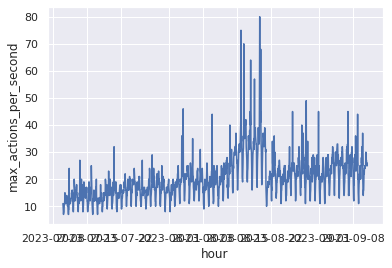

In [3]:
sns.set(rc={'figure.figsize':(12,7)})
sns.lineplot(data=df, y='max_actions_per_second', x='hour')

In [4]:
# Из данного графика видно, что нагрузка со временем увеличивалась, и значения во время проведения флешмоба стремительно возрастали

In [5]:
df['reg'] = df['hour'].apply(lambda date: 1 if (date >= pd.to_datetime('2023-08-13 00:00:00') and
                                                date < pd.to_datetime('2023-08-21 00:00:00')) else 0)

In [6]:
df.max_actions_per_second  = df.max_actions_per_second .astype(int) #преобразование в int для KTR

In [7]:
# Чтобы увеличить точность предсказательной модели и уменьшить влияние выбросов, логарифмируем данные

df.max_actions_per_second = np.log(df.max_actions_per_second)

In [8]:
df.tail()

,max_actions_per_second,hour,reg
1507,3.295837,2023-09-10 19:00:00,0
1508,3.218876,2023-09-10 20:00:00,0
1509,3.218876,2023-09-10 21:00:00,0
1510,3.258097,2023-09-10 22:00:00,0
1511,3.218876,2023-09-10 23:00:00,0


In [9]:
# Для предсказания выберем модель KTR, поскольку она взвешенно сочетает комбинацию тренда, сезонности
# и регрессора

ktr = KTR(response_col="max_actions_per_second",
          date_col="hour",
          seasonality=[24, 24*7], # укажем дневную и недельную сезонность
          regressor_col=['reg'],
          regressor_sign='+',
          estimator="pyro-svi",
          num_steps=600,
          n_bootstrap_draws=1000
         )

In [10]:
ktr.fit(df)

2023-09-15 15:31:00 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-09-15 15:31:00 - orbit - INFO - First time in running stan model:ktrlite. Expect 3 - 5 minutes for compilation.
2023-09-15 15:32:20 - orbit - INFO - Using SVI (Pyro) with steps: 600, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-09-15 15:32:20 - orbit - INFO - step    0 loss = 135.33, scale = 0.089814
INFO:orbit:step    0 loss = 135.33, scale = 0.089814
2023-09-15 15:32:54 - orbit - INFO - step  100 loss = -838.66, scale = 0.24533
INFO:orbit:step  100 loss = -838.66, scale = 0.24533
2023-09-15 15:33:37 - orbit - INFO - step  200 loss = -838.62, scale = 0.24439
INFO:orbit:step  200 loss = -838.62, scale = 0.24439
2023-09-15 15:34:19 - orbit - INFO - step  300 loss = -838.69, scale = 0.25385
INFO:orbit:step  300 loss = -838.69, scale = 0.25385
2023-09-15 15:34:53 - orbit - INFO - step  400 loss = -841.24, scale = 0.25994
INFO:orbit:step  400 loss = -841.24, sca

In [19]:
future_df = ktr.make_future_df(periods=24*7*2)

In [20]:
future_df['reg'] = 0

In [13]:
predicted_df = ktr.predict(df=future_df)

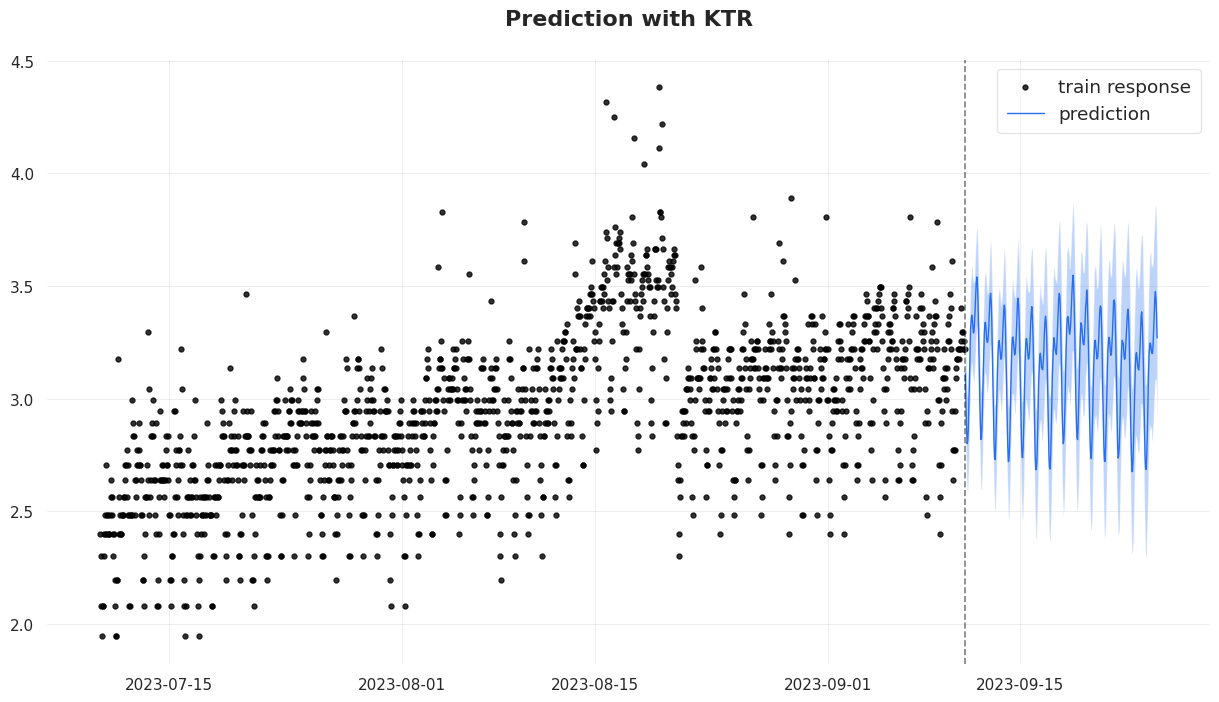

<Axes: title={'center': 'Prediction with KTR'}>

In [14]:
# Далее, строим графики
plot_predicted_data(df, predicted_df, "hour", 
                    'max_actions_per_second', 
                    title='Prediction with KTR',
                    figsize=(15,8),
                    lw=1) 

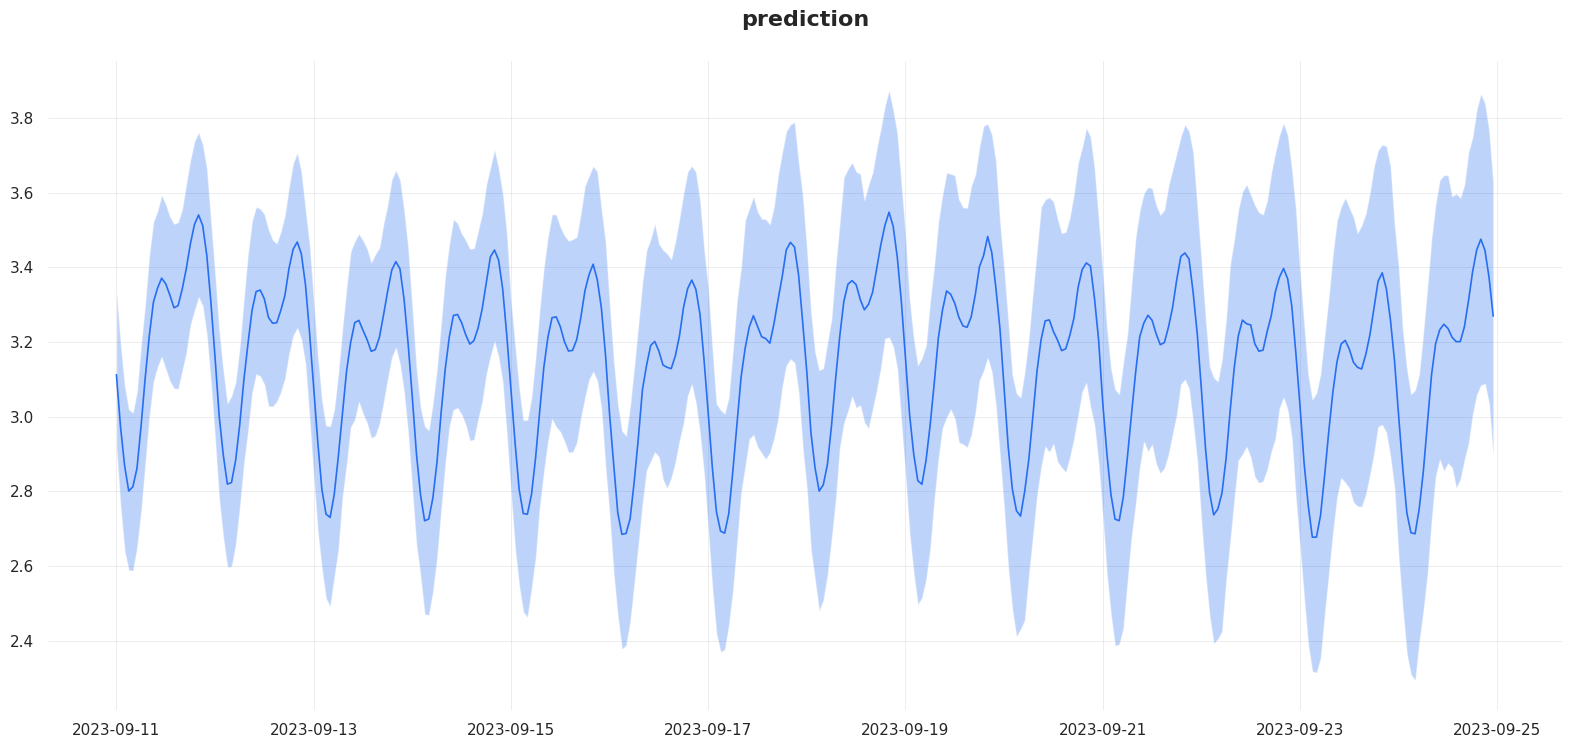

array([<Axes: title={'center': 'prediction'}>], dtype=object)

In [15]:
plot_predicted_components(predicted_df=predicted_df, date_col='hour', plot_components=['prediction', 'trend', 'seasonality_24', 'seasonality_24*7']) 

In [16]:
bt_exp = BackTester(
    model=ktr,
    df=df,
    min_train_len=24*7, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24*7, #на сколько происходит прирост тренировочных данных
    forecast_len=24*7*2, #горизонт прогнозирования
    window_type='expanding'
)

In [17]:
# Провалидируем модель

bt_exp.fit_predict() #обучаем
bt_exp.score() #выводим метрики

2023-09-15 15:36:14 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2023-09-15 15:36:14 - orbit - INFO - Using SVI (Pyro) with steps: 600, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
INFO:orbit:Using SVI (Pyro) with steps: 600, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-09-15 15:36:14 - orbit - INFO - step    0 loss = -43.579, scale = 0.090723
INFO:orbit:step    0 loss = -43.579, scale = 0.090723
2023-09-15 15:36:28 - orbit - INFO - step  100 loss = -83.19, scale = 0.18124
INFO:orbit:step  100 loss = -83.19, scale = 0.18124
2023-09-15 15:36:42 - orbit - INFO - step  200 loss = -83.316, scale = 0.17081
INFO:orbit:step  200 loss = -83.316, scale = 0.17081
2023-09-15 15:36:55 - orbit - INFO - step  300 loss = -82.029, scale = 0.17655
INFO:orbit:step  300 loss = -82.029, scale = 0.17655
2023-09-15 15:37:11 - orbit - INFO - step  400 loss 

,metric_name,metric_values,is_training_metric
0,smape,0.071374,False
1,wmape,0.072749,False
2,mape,0.071321,False
3,mse,0.076667,False
4,mae,0.218651,False
5,rmsse,1.565579,False


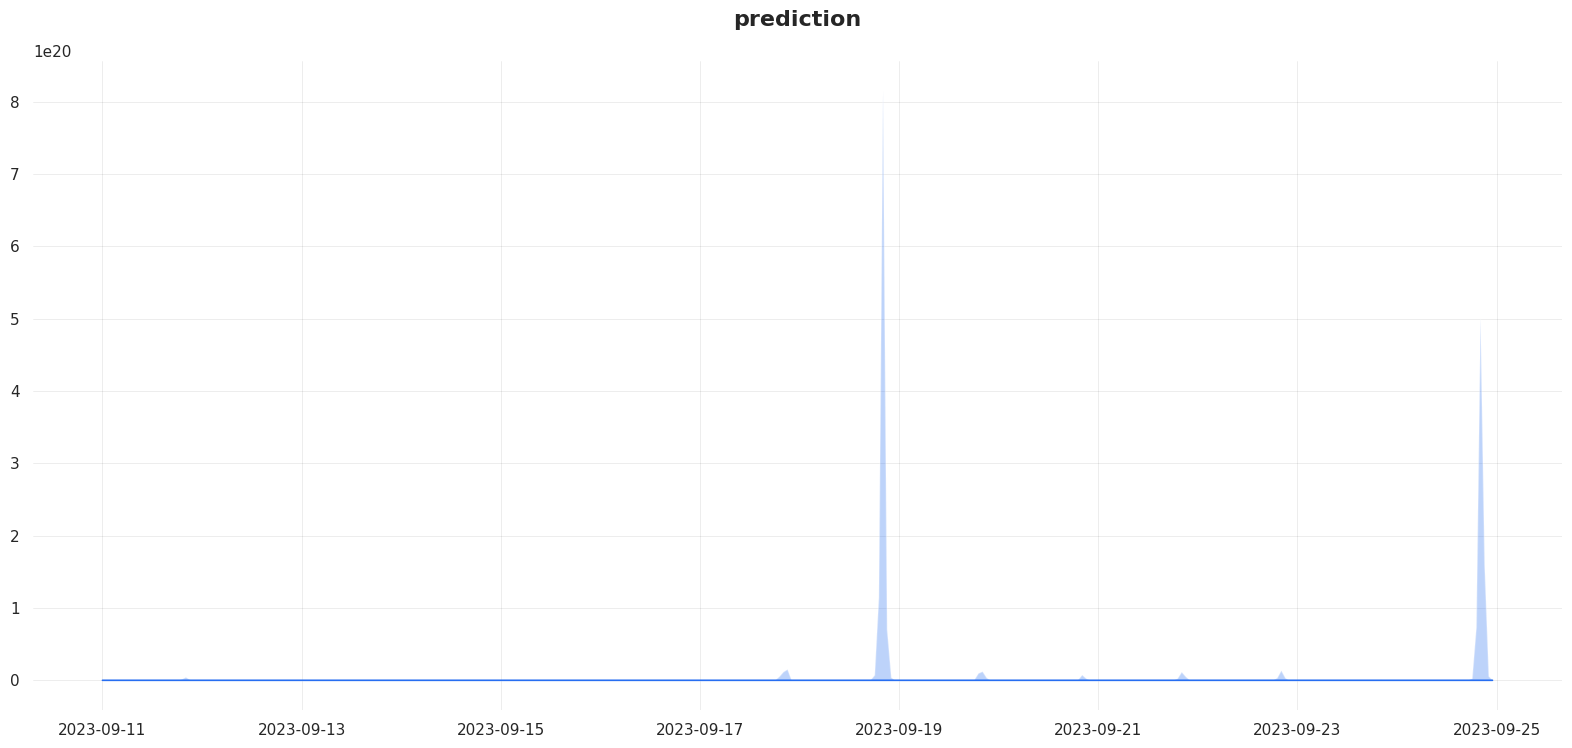

array([<Axes: title={'center': 'prediction'}>], dtype=object)

In [21]:
# Чтобы проинтерпретировать результаты, вернем логарифмированные данные к нашей метрике

df2 = predicted_df

df2['prediction'] = df2['prediction'].apply(lambda x: 2.718 ** x)
df2['prediction_5'] = df2['prediction_5'].apply(lambda x: 2.718 ** x)
df2['prediction_95'] = df2['prediction_95'].apply(lambda x: 2.718 ** x)

plot_predicted_components(predicted_df=df2, date_col='hour', plot_components=['prediction'])

ВЫВОД: на горизонте в 2 недели колебания составят примерно от 15 до 35 максимальных действий в секунду, в зависимости от времени суток и дня недели. 

Доверительный интервал отражает возможные выбросы - то есть приблизительно до 50 действий в секунду. Прогноз сделан без учета событий, во время флешмоба, где пиковые значения достигали 80.